In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import interp1d
from dataclasses import dataclass
import itertools
import networkx as nx


In [55]:
@dataclass(frozen=True)
class Node:
    x: float
    y: float 
    features: np.ndarray
        
    def as_dict(self):
        return {'x': self.x, 'y':self.y, 'features':self.features}
        

def line_motif(src, dst):

    n_points = int(np.sqrt((dst.x-src.x)**2 + (dst.y-src.y)**2) / 0.02)
    
    dx = np.linspace(src.x, dst.x, n_points)
    dy = np.linspace(src.y, dst.y, n_points)
    
    linfit = interp1d([0, 1], np.vstack([src.features, dst.features]), axis=0)
    dfeatures = linfit(np.linspace(0, 1, n_points))
    
    return [Node(x, y, f) for x, y, f in zip(dx, dy, dfeatures)]

def random_node(rng, features):
    node = Node(
        x=rng.uniform(0, 1), 
        y=rng.uniform(0, 1), 
        features=features,
    )
    return node

In [56]:
def make_spatial_nodes(n_lines, n_features):
    rng = np.random.default_rng()
    chaff = [random_node(rng, rng.uniform(0., 1., size=(n_features,))) for _ in range(100)]
    lines = []
    ground_truth = []
    
    for n in range(n_lines):
        src = random_node(rng, np.ones((n_features,)))
        dst = random_node(rng, np.ones((n_features,)))        
        line = line_motif(src, dst)
        lines += line
        ground_truth.append(line)
    
    all_nodes = chaff + lines
    
    return all_nodes, ground_truth, line

In [57]:
def find_neighbors(tri, nodes, query):

    qidx = nodes.index(query)
    
    try:
        
        nslice = slice(
            tri.vertex_neighbor_vertices[0][qidx],
            tri.vertex_neighbor_vertices[0][qidx+1],
        )

        idx = tri.vertex_neighbor_vertices[1][nslice]
    except: 
        idx = list(tri[qidx])
    
    return [nodes[i] for i in idx]

In [58]:
def find_neighbors_n_hop(tri, nodes, query, n_hop=1):
    
    neighbors = find_neighbors(tri, nodes, query)
    search_nodes = list(neighbors)
    for hop in range(1, n_hop):
        new_nodes = []
        while search_nodes:
            new_query = search_nodes.pop(0)
            new_nodes.extend(find_neighbors(tri, nodes, new_query))
        search_nodes = new_nodes
        neighbors.extend(new_nodes)
        
    # remove duplicates (note, ``Node`` is unhashable)
    unique_neighbors = []
    [unique_neighbors.append(obj) for obj in neighbors if obj not in unique_neighbors]
    return unique_neighbors

In [59]:
def identify_motifs(nodes, graph, query, n_hop=1, random_sample = True):
    """Identify graph motifs given a subset of the nodes
    nodes : list of all relevant nodes
    graph : full graph
    query : sample subgraph from which to find the motif (list of nodes in the input query)
    n_hop : number of hops for neighbourhood of node
    """
    
    #subgraphs = get_neighbour_subgraph(graph,nodes,query,n_hop)
    sampled_graphs = sampling_query(query, 3)
    subgraphs = [graph.subgraph(item) for item in sampled_graphs]
    print("got subgraphs")
    

    # given the subgraphs identify a motif within the interest 
    motif = retrieve_motif(subgraphs, query)
    print("got motif: ")
    print(motif.nodes)
    query_nodes = None
    
    if random_sample:
        extra_nodes = random.sample(range(100, len(graph.nodes)), 10) + random.sample(range(0, 100), 10)
        print("extra_nodes: ")
        print(extra_nodes)
        query_nodes = graph.subgraph(extra_nodes)
        
    # apply the subgraph matching to seed nodes from the full graph
    all_candidates = find_motif_in_graph(motif, graph, nodes, query_nodes, n_hop=1)
    
    return motif, all_candidates

In [60]:
def sampling_query(query, sample_size):
    sm = sample_size
            #for every subgraph of size sm of the query graph, check if isomorphic to motif
                # if yes, count +=1
    product_sm = []
    for i in range(0, sm):
        product_sm.append(query.nodes)
        # sampling the query graph into all the possible chunks of size sm
    sample = list(itertools.product(*product_sm))
    sample = [trip for trip in sample if len(list(set(trip))) == sm]
        
    u_sample = []
    for triplet in sample:
        a = list(triplet)
        a.sort()
        if not u_sample.count(a):
            u_sample.append(a)
    
    return u_sample
    

In [61]:
def find_motif_in_graph(motif, graph, nodes, query_nodes = None, n_hop=1):
    """ Search for copies of the motif on the graph
    Input
    motif : template to search along the graph
    graph : full graph
    n_hop : number of hops for neighbourhood of each node
    query_nodes : list of pre-selected nodes which could potentially fit the motif
    
    Output
    sample_list : list of all the subgraphs that are isomorphic to the motif
    """
    
    # check for features of nodes in motif
    # for each node in the graph, check if features match the motif_node features
    # if features match, check if motif
    sample_list = []
    size_motif = len(motif)
    
    if query_nodes is not None:
        subgraphs_temp = get_neighbour_subgraph(graph, nodes, query_nodes, n_hop)
        subgraphs = []
        i=0
        for subgraph in subgraphs_temp:
            subgraph_unfrozen = nx.Graph(subgraph)
            subgraph_unfrozen.add_node(list(query_nodes.nodes)[i])
            i+=1
            subgraphs.append(subgraph_unfrozen)
    else: 
        subgraphs = get_neighbour_subgraph(graph, nodes, graph, n_hop)
    
    for subgraph in subgraphs:
        sm = len(motif.nodes)
            #for every subgraph of size sm of the query graph, check if isomorphic to motif
                # if yes, count +=1
        product_sm = []
        for i in range(0, sm):
            product_sm.append(subgraph.nodes)
        # sampling the query graph into all the possible chunks of size sm
        sample = list(itertools.product(*product_sm))
        sample = [trip for trip in sample if len(list(set(trip))) == sm]
        
        u_sample = []
        for triplet in sample:
            a = list(triplet)
            a.sort()
            if not u_sample.count(a):
                u_sample.append(a)
        
        count = 0
        for trip in u_sample:
            trip.sort()
            sub_gr = graph.subgraph(trip)
            if edges_exist(graph, sub_gr): 
                if nx.could_be_isomorphic(sub_gr, out_motif) and check_features(sub_gr, out_motif):
                    sample_list.append(sub_gr)
    
    return sample_list

In [62]:
def edges_exist(graph, subgraph):
    """ Checks whether the mentioned nodes are directly connected in the general graph."""
    count_edges = 0
    list_nodes = list(subgraph.nodes)
    for i in range(0, len(list_nodes)-1):
        for j in range(i+1, len(list_nodes)):
            if graph.has_edge(list_nodes[i], list_nodes[j]):
                count_edges += 1
    if count_edges >= (len(list_nodes)-1):
        return True
    else:
        return False

In [63]:
def check_features(subgraph, motif):
    """place holder function for feature comparison. in the sample case, only checks if sum(features) is 5"""
    value = [sum(subgraph.nodes[i]['features']) for i in list(subgraph.nodes)]
    
    if sum(value) == len(subgraph)*5:
        return True
    else:
        return False

In [64]:
def get_neighbour_subgraph(graph,nodes,query,n_hop=1):
    """ Retrief the subgraph of neighboring nodes for each node in the query.
    Input
    nodes : list of all relevant nodes
    graph : full graph
    query : sample subgraph
    n_hop : number of hops for neighbourhood of node
    
    Output
    subgraphs : subgraphs for the neighbouring nodes
    """
    subgraphs = []
    
    # iterate over each query node and find the n_hop neighbors
    for node in query.nodes:
        neighbors = find_neighbors_n_hop(graph, nodes, nodes[node], n_hop)
        # neighbors is a list of Node, but we need the list of indices for each node in the graph 
        neighbors_index = [nodes.index(neighbor) for neighbor in neighbors]
            
        # store each one as a subgraph
        subgraph = graph.subgraph(neighbors_index) # assuming graph is nx.Graph()
        subgraphs.append(subgraph)
        
    return subgraphs


In [65]:
def retrieve_motif(motif_list, query_graph):
    """ Identify the motif given a sample graph
    Input
    motif_list : list of candidates
    query_graph : list of graph from where the motifs are retrieved
    
    Output:
    out_motif : motif with the highest repeat within the query_graph from the motif_list
    """
    
    min_count = -1
    nodes = query_graph.nodes()
    out_motif = None
    for motif in motif_list:
        sm = len(motif.nodes)
            #for every subgraph of size sm of the query graph, check if isomorphic to motif
                # if yes, count +=1
        product_sm = []
        for i in range(0, sm):
            product_sm.append(nodes)
        # sampling the query graph into all the possible chunks of size sm
        sample = list(itertools.product(*product_sm))
        sample = [trip for trip in sample if len(list(set(trip))) == sm]
        sample = map(list, map(np.sort, sample))
        u_sample = []
        [u_sample.append(trip) for trip in sample if not u_sample.count(trip)]
        count = 0
        for trip in u_sample:
            sub_gr = query_graph.subgraph(trip)
            if edges_exist(query_graph, sub_gr): 
                if nx.could_be_isomorphic(sub_gr, motif):
                    count += 1
        
            #count motif in the subgraph
        if count > min_count:
            min_count = count
            out_motif = motif
    
    return out_motif

## Running the code

First, we need to make the nodes, and create the Delaunay graph between those points (i.e., make edges between the points without edge intersection. 

In [66]:
nodes, gt, line = make_spatial_nodes(n_lines=3, n_features=5)
points = np.asarray([[n.x, n.y] for n in nodes])
tri = Delaunay(points)

In [67]:
edges = []

nodes_as_dict = [node.as_dict() for node in nodes]
m = dict(enumerate(nodes_as_dict)) # mapping from vertices to nodes

for i in range(tri.nsimplex):
    edges.append( [tri.vertices[i,0], tri.vertices[i,1]] )
    edges.append( [tri.vertices[i,1], tri.vertices[i,2]] )
    edges.append( [tri.vertices[i,2], tri.vertices[i,0]] )

Create extra points that make up the lines. One of the lines will be used as the "selection" example further down.

In [68]:
line_points = np.asarray([[n.x, n.y] for n in line])
line_nodes = []
for sub_line in line_points:
    node = np.where(points == sub_line)[0][0]
    line_nodes.append(node)

In [69]:
G = nx.Graph(edges)
pos = dict(zip(m.keys(),points))

# maps attributes to the nodes
nx.set_node_attributes(G,m) 

line_graph = G.subgraph(line_nodes)

QUERY_NODE = nodes[105]

neighbors = find_neighbors_n_hop(tri, nodes, QUERY_NODE, n_hop=1)

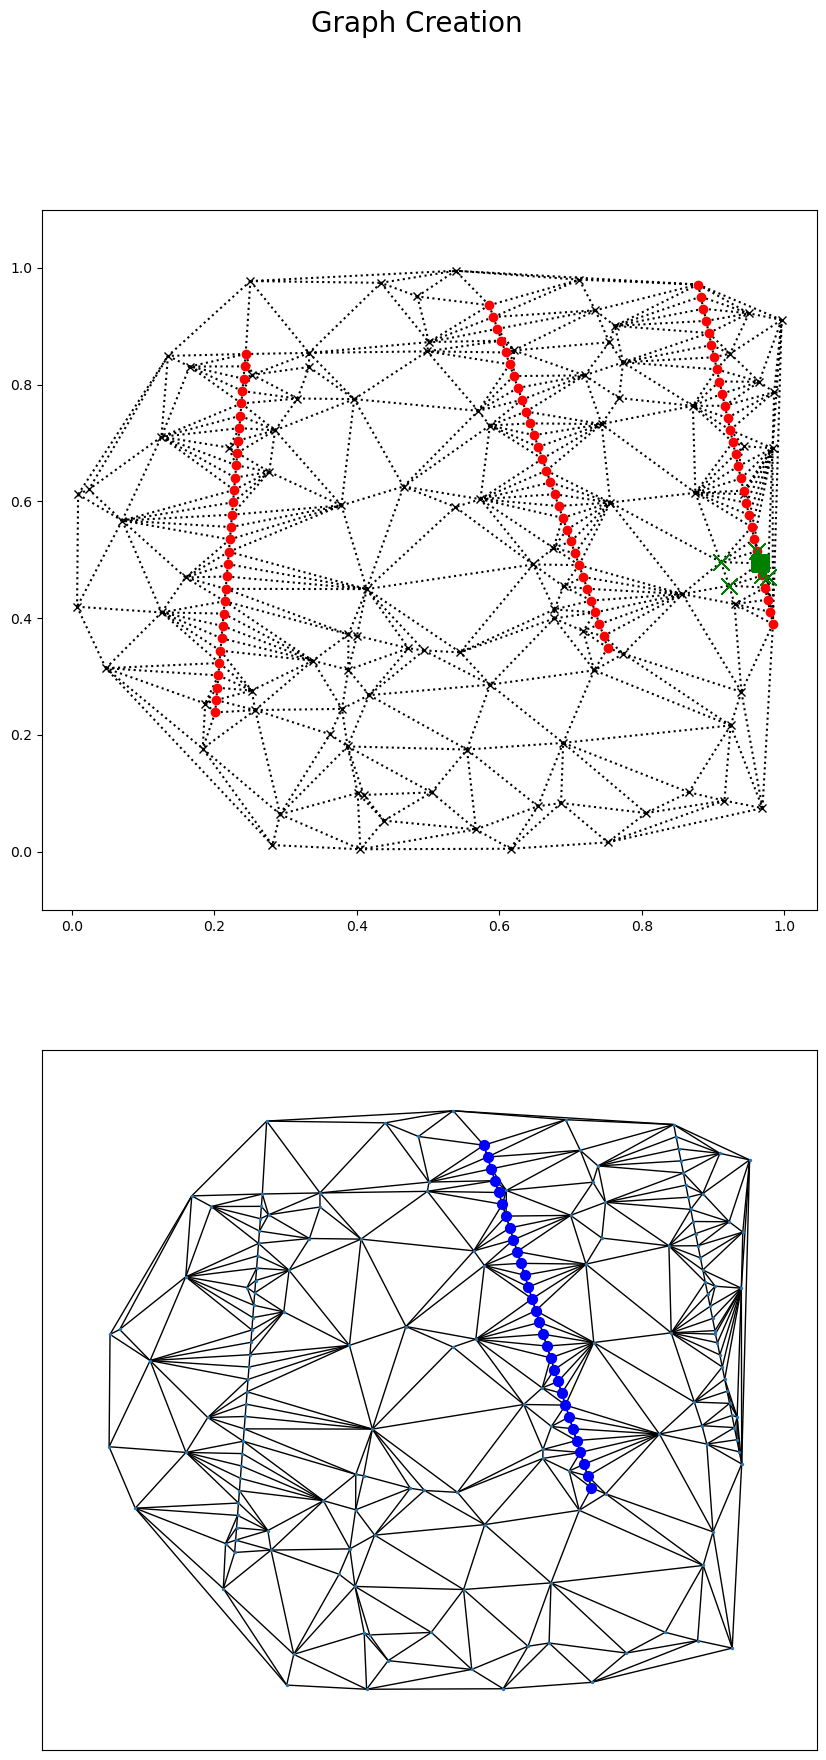

In [70]:
fig, axs = plt.subplots(2, 1, figsize=(10,20), sharey=True)

#plt.figure(figsize=(16, 16))
axs[0].triplot(points[:,0], points[:,1], tri.simplices, "k:")
for node in nodes:
    if np.sum(node.features) == 5:
        marker = "ro"
    else:
        marker = "kx"
    axs[0].plot(node.x, node.y, marker)
    axs[0].plot(QUERY_NODE.x, QUERY_NODE.y, "gs", markersize=12, markerfacecolor=None)
    
    for n in neighbors:
        axs[0].plot(n.x, n.y, 'gx', markersize=12)

#plt.show()


#nx.draw(G,pos)
#plt.show()



axs[1] = nx.draw_networkx(G,pos, node_size=2, with_labels = False)
nx.draw_networkx(line_graph, ax = axs[1], pos=pos, node_color = 'b', node_size=50, with_labels = False)
fig.suptitle('Graph Creation', fontsize = 20)

plt.show()


Note: if the test motif is not fully connected, it won't work properly on the retrieve_motif because it searches for the connected n-plets of the query graph.

From a list of candidate motifs, we can retrieve the one with the higher counts.

In [71]:
test_motif = line_graph.subgraph([180, 181, 182])
line_graph.nodes

NodeView((159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188))

In [72]:
query_graph = line_graph
motif_list = [test_motif, line_graph.subgraph([154, 155,156])]
out_motif=retrieve_motif(motif_list, query_graph)
out_motif.nodes

NodeView((180, 181, 182))

In [73]:
motif_list[0].nodes, motif_list[1].nodes

(NodeView((180, 181, 182)), NodeView(()))

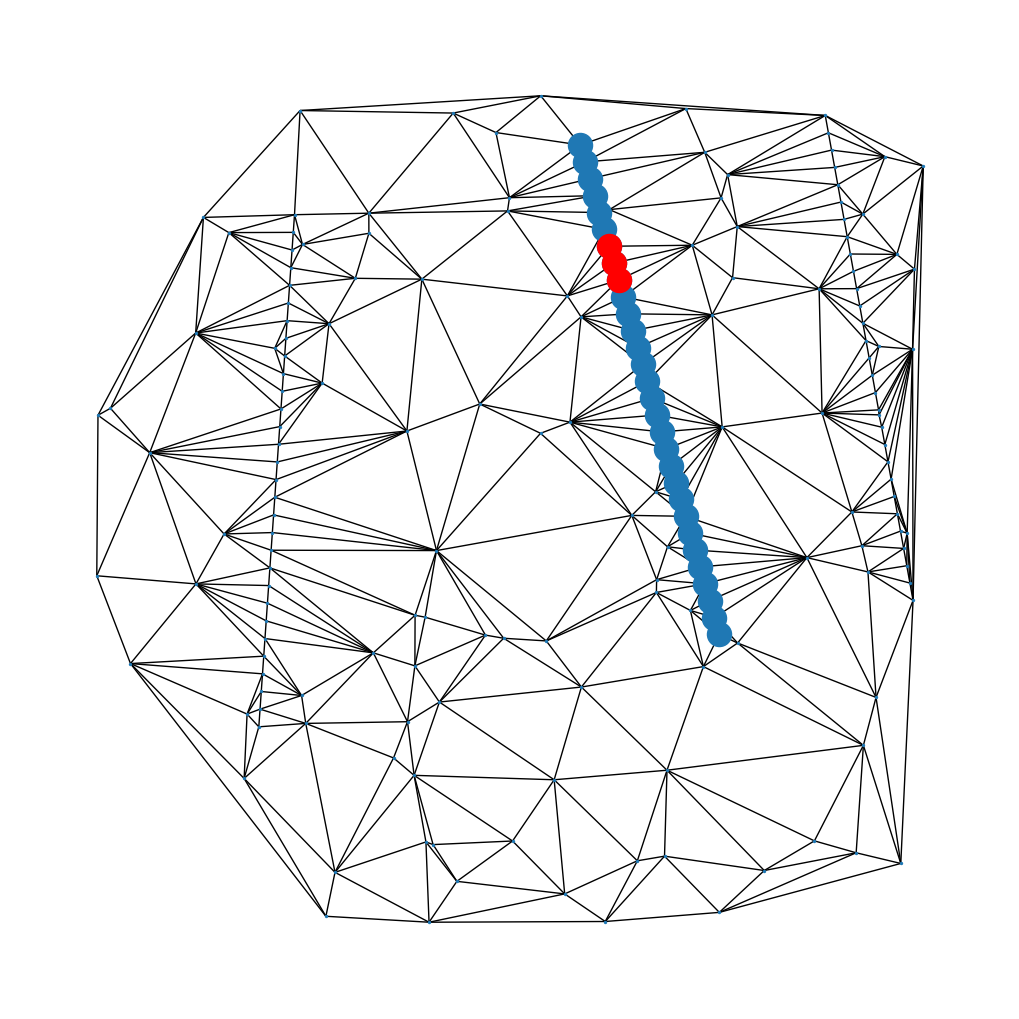

In [74]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
nx.draw(line_graph, pos=pos)
nx.draw(out_motif, pos=pos,node_color = 'r')
#plt.title("Motif selection from example line", fontsize = 20)
#plt.savefig("graph_selection_motif.png")

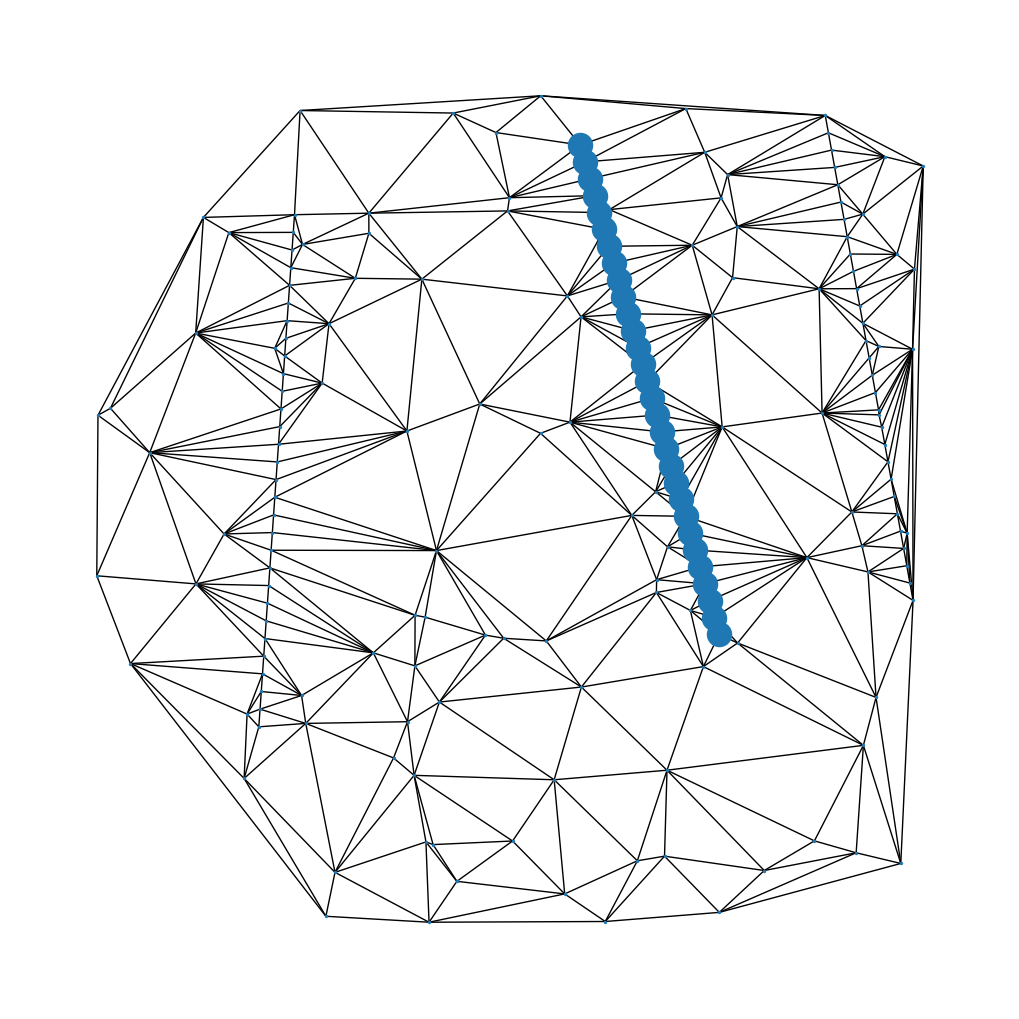

In [75]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
nx.draw(line_graph, pos=pos)
#plt.title("Motif selection from example line", fontsize = 20)
#plt.savefig("graph_selection.png")


In [76]:
subgraphs = get_neighbour_subgraph(G, nodes, query_graph, 1)

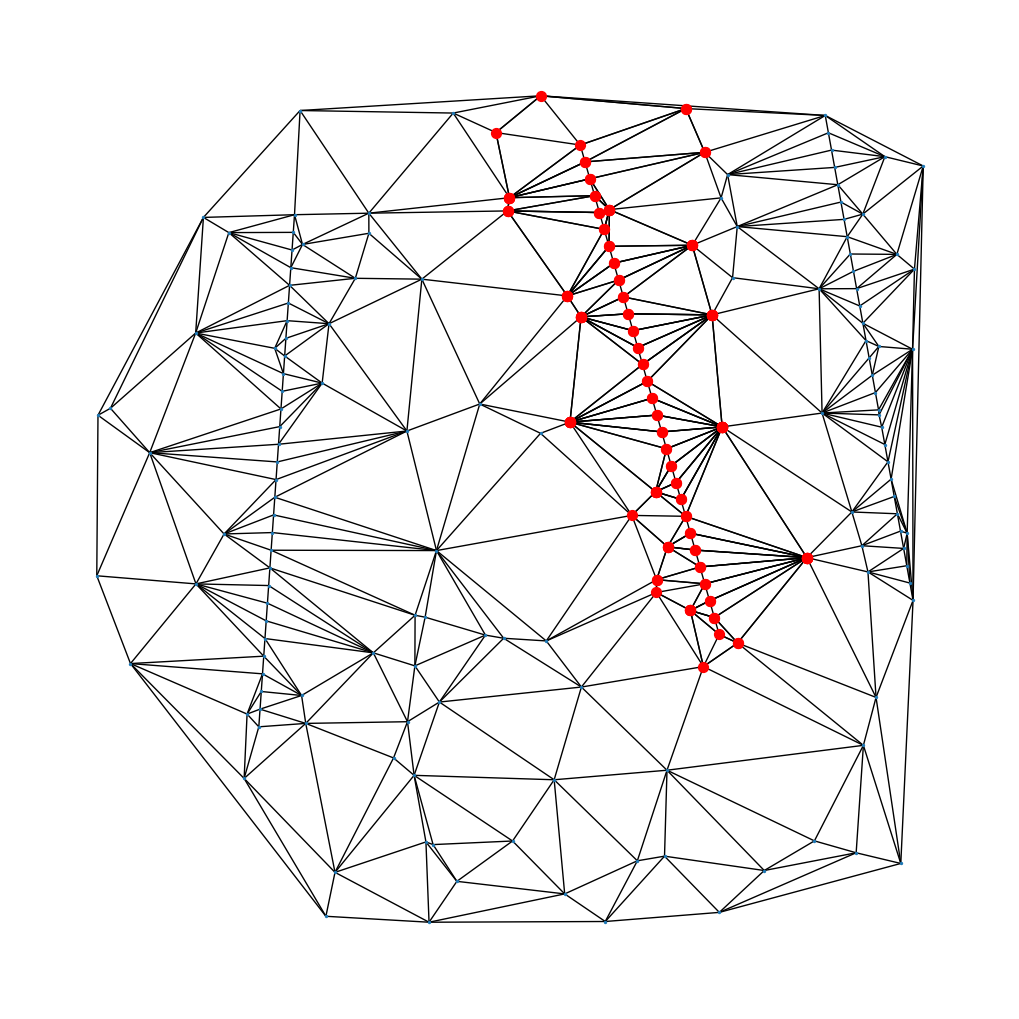

In [77]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in subgraphs:
    nx.draw(item, pos=pos,node_color = 'r', node_size=50, with_labels = False)

Sampling the subgraph (selection + neighbourhood) into triplets

In [78]:
subgraph = subgraphs[2]
sm = len(out_motif.nodes)
product_sm = []
for i in range(0, sm):
    product_sm.append(subgraph.nodes)
sample = list(itertools.product(*product_sm))

In [79]:
sample = [trip for trip in sample if len(list(set(trip))) == sm]

In [80]:
u_sample = []
for triplet in sample:
    a = list(triplet)
    a.sort()
    if not u_sample.count(a):
        u_sample.append(a)
u_sample

[[20, 160, 162], [52, 160, 162], [20, 52, 160], [20, 52, 162]]

Check isomorphism and feature similarity of the triplets insi

In [81]:
count = 0
for trip in u_sample:
    sub_gr = G.subgraph(trip)
    print(sub_gr.nodes)
    if G.has_edge(list(sub_gr.nodes)[0], list(sub_gr.nodes)[1]) and G.has_edge(list(sub_gr.nodes)[1], list(sub_gr.nodes)[2]): 
        if nx.is_isomorphic(sub_gr, out_motif) and check_features(sub_gr, out_motif):
            print(sub_gr.nodes)

[160, 162, 20]
[160, 162, 52]
[160, 20, 52]
[162, 20, 52]


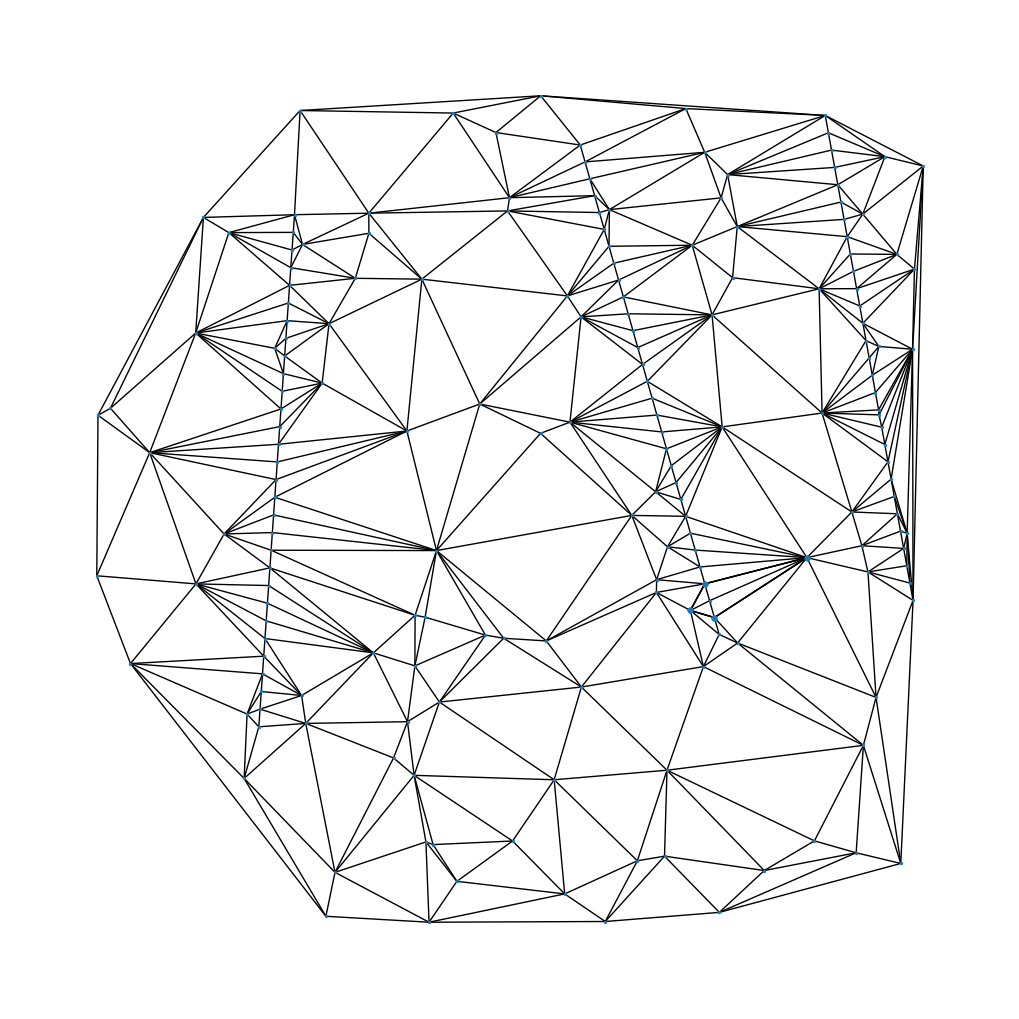

In [82]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in u_sample:
    nx.draw(G.subgraph(item), pos=pos, node_size=10, with_labels = False)

In [83]:
sample_list = find_motif_in_graph(out_motif, G, nodes, query_nodes = query_graph, n_hop=1)

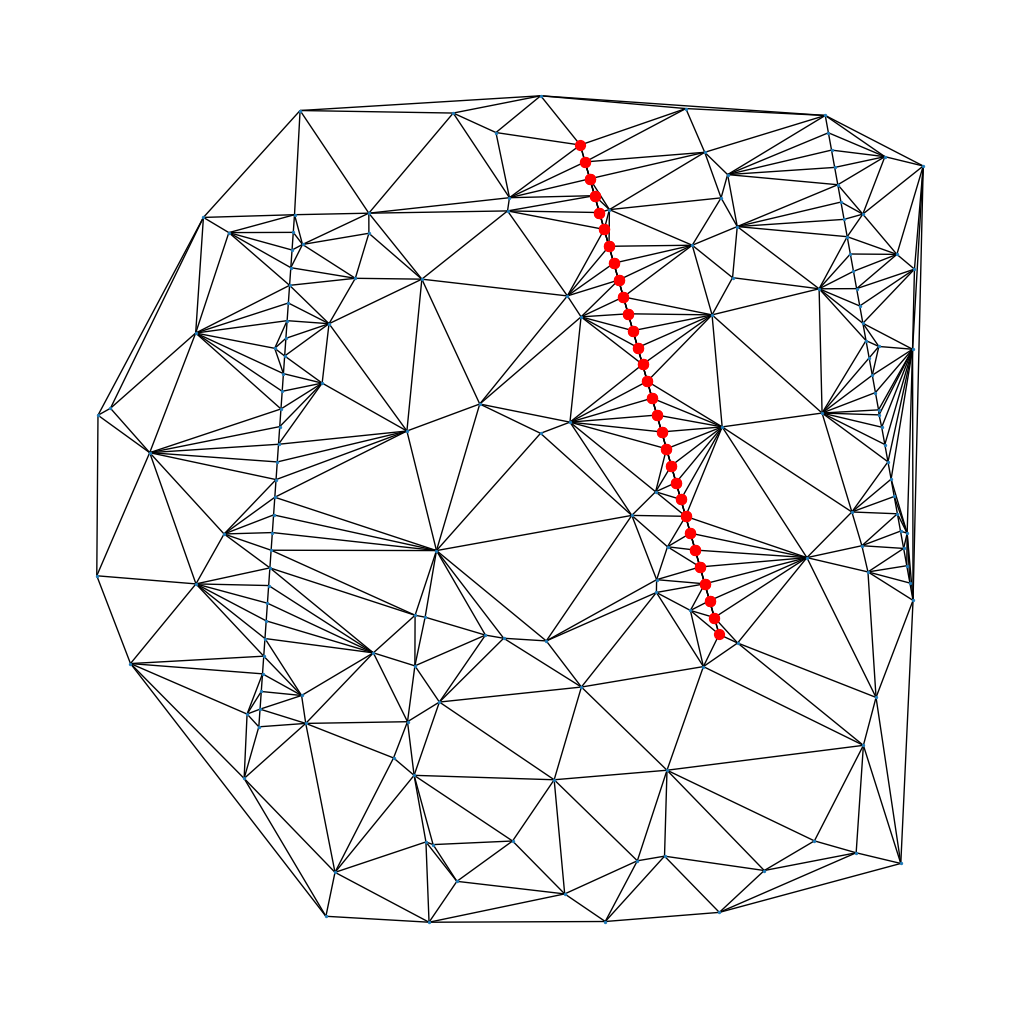

In [84]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in sample_list:
    nx.draw(item, pos=pos, node_size=50,node_color = "r", with_labels = False)

## Sampling the nodes and searching

Random sampling of nodes in the graph to search for the ones that are isomorphic/similar features to the motif

In [85]:
import random
extra_nodes = random.sample(range(100, len(points)), 10) + random.sample(range(0, 100), 10)

In [86]:
query_graph_extra = G.subgraph(extra_nodes)

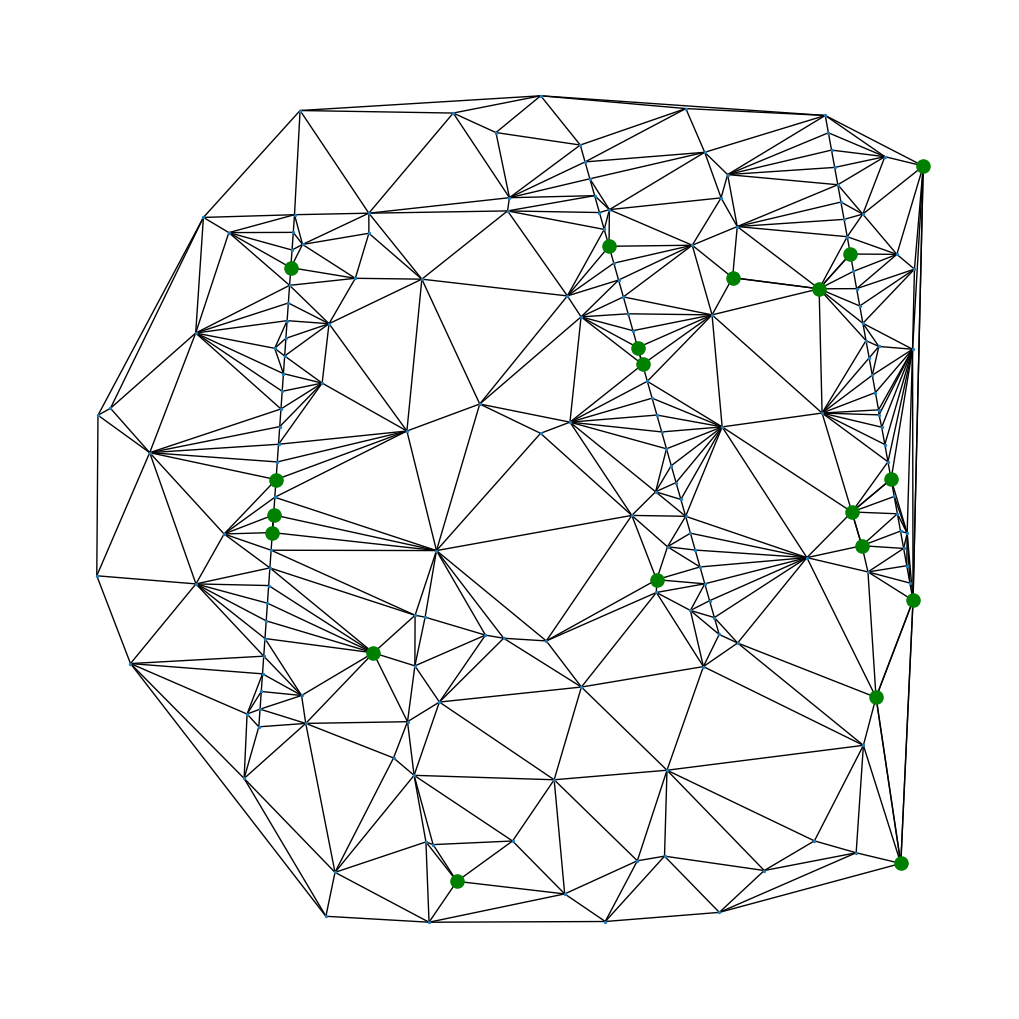

In [87]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
nx.draw(query_graph_extra, pos=pos, node_size=90,node_color = "g", with_labels = False)
#plt.savefig("graph_sample.png")

In [88]:
sample_list_extra = find_motif_in_graph(out_motif, G, nodes, query_nodes = query_graph_extra, n_hop=1)

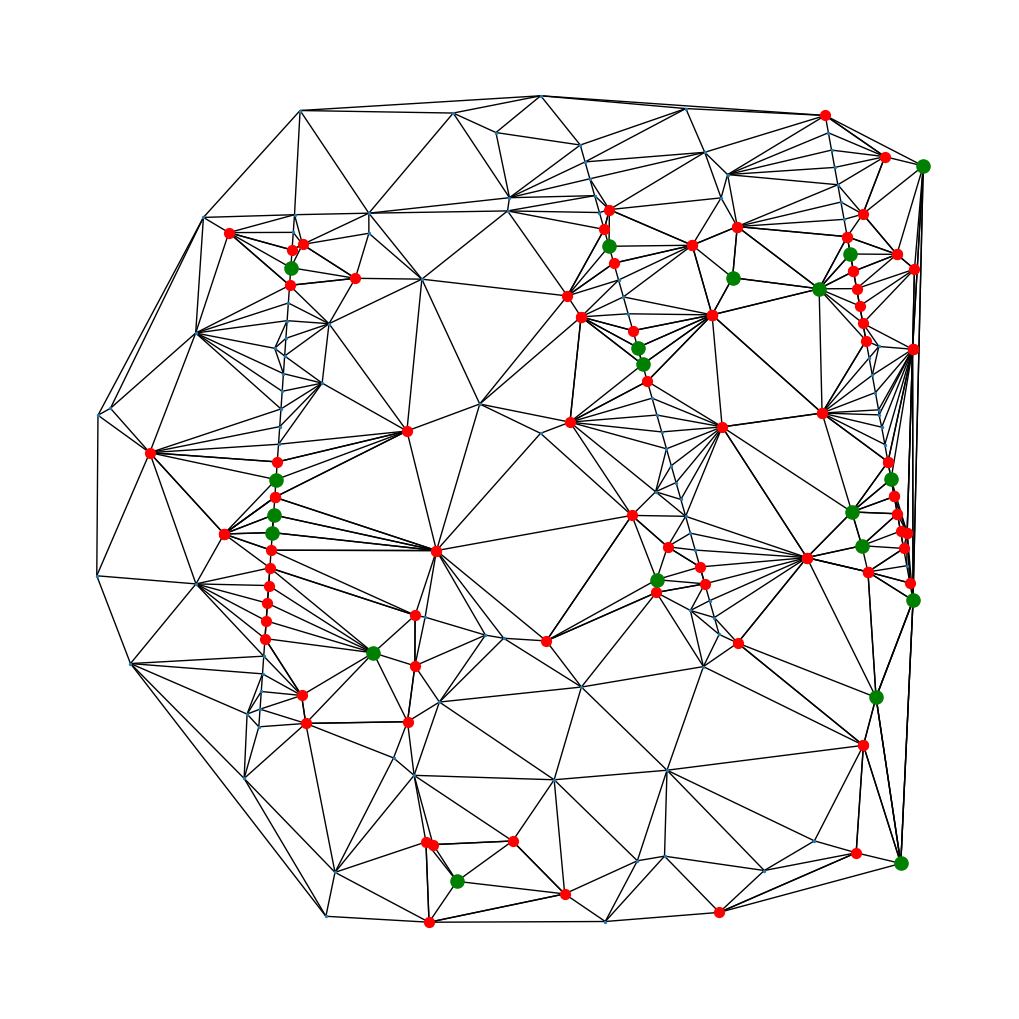

In [89]:
subgraphs_extra = get_neighbour_subgraph(G, nodes, query_graph_extra, 1)
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in subgraphs_extra:
    nx.draw(item, pos=pos, node_size=50,node_color = "r", with_labels = False)
nx.draw(query_graph_extra, pos=pos, node_size=90,node_color = "g", with_labels = False)
plt.savefig("graph_sample_neighbours.png")

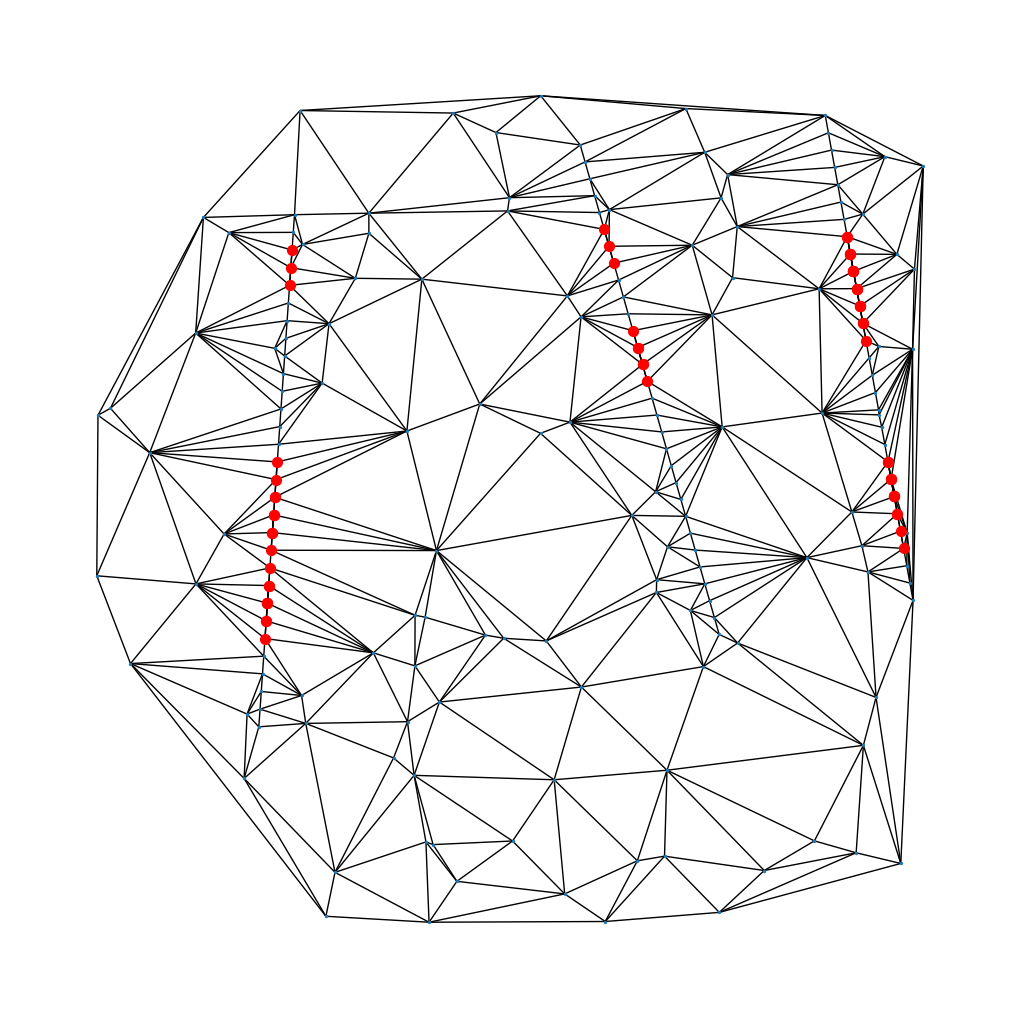

In [90]:
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in sample_list_extra:
    nx.draw(item, pos=pos, node_size=50,node_color = "r", with_labels = False)
plt.savefig("graph_motif_search.png")

# Refined searches: GCN and GNN

In [91]:
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
import torch

from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric
from collections import defaultdict

Getting all the nodes from the graph to check how training goes with all.

note: to test with the sample selections, just substitute _subgraphs_full_ with _subgraphs_extra_

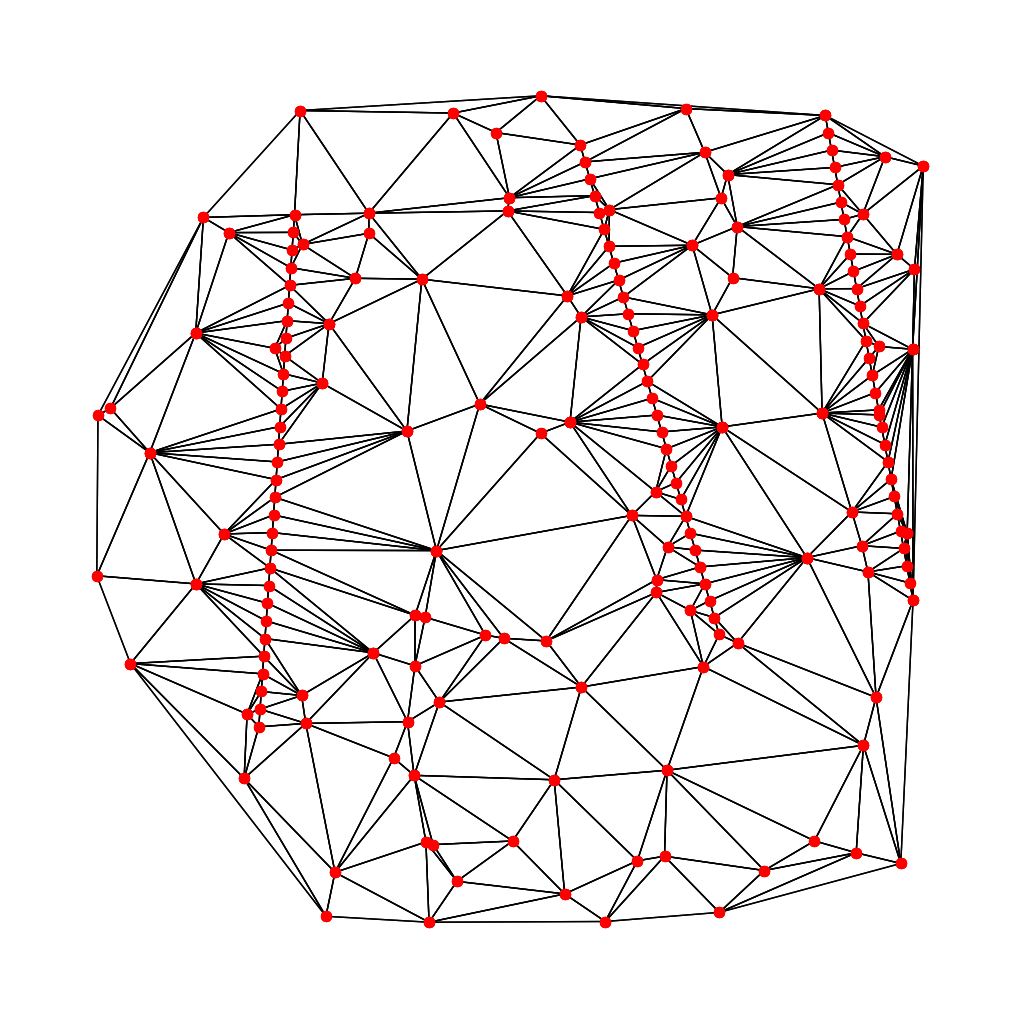

In [92]:
subgraphs_full = get_neighbour_subgraph(G, nodes, G, 1)
plt.figure(figsize=(10,10))
nx.draw(G,pos, node_size=2, with_labels = False)
for item in subgraphs_full:
    nx.draw(item, pos=pos, node_size=50,node_color = "r", with_labels = False)

Converting our data into the data that torch geometric handles:

_x_ - feature matrix for nodes

_pos_ - positions in space (x, y)

_edge_index_ - edges

_y_ - target (binary, whether it's a relevant graph or not. Criteria used: has more than 3 nodes that have the features needed)

In [93]:
datalist=[]

for item in subgraphs_full:
    item = nx.convert_node_labels_to_integers(item)
    item = item.to_directed() if not nx.is_directed(item) else item

    if isinstance(item, (nx.MultiGraph, nx.MultiDiGraph)):
        edges = list(item.edges(keys=False))
    else:
        edges = list(item.edges)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    #datalist.append(from_networkx(item))
    temp_data = defaultdict(list)
    #x = item.features
    temp_data['edge_index'] = edge_index
    for i, (_, feat_dict) in enumerate(item.nodes(data=True)):
        for key, value in feat_dict.items():
            if key == 'features':
                temp_data['x'].append(np.ndarray.tolist(value))
                if sum(value) == 5:
                    target = 1
                else:
                    target = 0
            if key == 'x':
                x = value
            if key == 'y':
                y = value
        temp_data['pos'].append([x,y])
        temp_data['y'].append(target)
        
    temp_data['x'] = torch.Tensor(temp_data['x'])
    temp_data['pos'] = torch.Tensor(temp_data['pos'])
    y= 0
    if sum(temp_data['y']) >= 3:
        y = 1

    # _y = F.one_hot( torch.as_tensor(y), num_classes=2)
    # print(y, _y)
    
    temp_data_final = torch_geometric.data.Data(
        x = temp_data['x'], 
        edge_index = temp_data['edge_index'], 
        pos = temp_data['pos'], 
        y = torch.as_tensor(y), #F.one_hot( torch.as_tensor(y), num_classes=2),
    )
    datalist.append(temp_data_final)
    #datalist.append(torch_geometric.data.Data(x=temp_data['features'], edge_index=edge_index))

In [94]:
datalist

[Data(x=[7, 5], edge_index=[2, 12], y=0, pos=[7, 2]),
 Data(x=[6, 5], edge_index=[2, 12], y=0, pos=[6, 2]),
 Data(x=[5, 5], edge_index=[2, 8], y=0, pos=[5, 2]),
 Data(x=[14, 5], edge_index=[2, 28], y=1, pos=[14, 2]),
 Data(x=[7, 5], edge_index=[2, 12], y=0, pos=[7, 2]),
 Data(x=[7, 5], edge_index=[2, 14], y=0, pos=[7, 2]),
 Data(x=[6, 5], edge_index=[2, 12], y=0, pos=[6, 2]),
 Data(x=[4, 5], edge_index=[2, 6], y=0, pos=[4, 2]),
 Data(x=[5, 5], edge_index=[2, 10], y=0, pos=[5, 2]),
 Data(x=[8, 5], edge_index=[2, 16], y=0, pos=[8, 2]),
 Data(x=[6, 5], edge_index=[2, 10], y=0, pos=[6, 2]),
 Data(x=[8, 5], edge_index=[2, 16], y=0, pos=[8, 2]),
 Data(x=[5, 5], edge_index=[2, 10], y=0, pos=[5, 2]),
 Data(x=[4, 5], edge_index=[2, 8], y=0, pos=[4, 2]),
 Data(x=[8, 5], edge_index=[2, 16], y=0, pos=[8, 2]),
 Data(x=[5, 5], edge_index=[2, 10], y=0, pos=[5, 2]),
 Data(x=[5, 5], edge_index=[2, 8], y=0, pos=[5, 2]),
 Data(x=[7, 5], edge_index=[2, 14], y=0, pos=[7, 2]),
 Data(x=[7, 5], edge_index=[2,

In [95]:
train_dataset = datalist[:round(0.7*len(datalist))]
test_dataset = datalist[round(0.7*len(datalist)):]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [96]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[379, 5], edge_index=[2, 750], y=[64], pos=[379, 2], batch=[379], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[386, 5], edge_index=[2, 756], y=[64], pos=[386, 2], batch=[386], ptr=[65])

Step 3:
Number of graphs in the current batch: 4
DataBatch(x=[17, 5], edge_index=[2, 30], y=[4], pos=[17, 2], batch=[17], ptr=[5])



In [97]:

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(5, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [98]:
datalistmodel = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 002, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 003, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 004, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 005, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 006, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 007, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 008, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 009, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 010, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 011, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 012, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 013, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 014, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 015, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 016, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 017, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 018, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 019, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 020, Train Acc: 0.7576, Test Acc: 0.8070
Epoch: 021, Train Acc: 0.7576, Test Acc: